# Comparing the Jaynes-Cummings and Tavis-Cummings Hamiltonians


In this Assignment we will investigate the Tavis-Cummings Hamiltonian for an ensemble of homogeneous 'atoms' and compare it to the Jaynes-Cummings Hamiltonian. The assignment consists of 2 parts: Part I is 3 analytical derivation questions & Part II is a numerical exercise using Qutip.

## Part I : Analytical questions (10 marks)

The Tavis-Cummings Hamiltonian can be written

$$
H_{TC} = \omega_c a^{\dagger} a + \displaystyle \sum_j^N \left\{ \frac{\omega_j}{2} \sigma^z_j + g_j (a \sigma^+_j + a^\dagger \sigma^-_j) \right\},
$$

where we define the operators such that $[a,a^\dagger]=1$ and $\sigma^z_j = |e_j\rangle\langle e_j| - |g_j\rangle\langle g_j|$, $\sigma^+_j = |e_j\rangle\langle g_j|$ and $\sigma^-_j = (\sigma^+_j)^\dagger$.

### Question 1:

Let's define the collective spin operators: $J_{\pm}$ as follows 
$
J_{\pm} = \displaystyle \sum_{j = 1}^N \sigma^{\pm}_j
$

Show that the commutator $[J_{+}, J_{-}] = \displaystyle \sum_{j = 1}^N \sigma^z_j$

### Answer 1:

<img src = 'image3.png'>

### Question 2:

Define the collective spin operators $\Sigma_{z} = \displaystyle \sum_{j = 1}^N \sigma^z_j$ and $\Sigma_{\pm} = \displaystyle \sum_{j=1}^N \dfrac{g_j}{\sqrt{\sum_{k=1}^N |g_k|^2}} \sigma^{\pm}_j$.

Show that in the special case where all the 'atoms' are resonant with the cavity mode and homogeneously coupled to the cavity ($\omega_i = \omega_a$ \& $g_i = g$ for all $i$),  $H_{TC}$ can be rewritten as

$$
H_{TC} = \omega_c a^\dagger a + \dfrac{\omega_a}{2} \Sigma_z + \Omega (a \Sigma_+ + a^\dagger \Sigma_-) ,
$$

where $\Omega = g\sqrt{N}$

### Answer 2:

<img src = 'image4.png'>

### Question 3:

Consider the transmission spectrum $T(\omega)$ defined for 2 'atoms' in the Evans *et al.* paper (p.10 Lecture 4) that includes cavity and atomic loss rates $\kappa$ and $\gamma_i$ respectively. Show that the transmission spectrum $T(\omega)$ for $N$ identical 'atoms' can be approximated as $T(\omega)$ of one 'super-atom' with coupling strength $\Omega = g\sqrt{N}$.

<img src = 'image5.png'>
<img src = 'image6.png'>

### Answer 3:
Approach: Find transmission spectrum of N atoms and find transmission spectrum of one super-atom and show that they are equal.

In [1]:
import sympy as smp

In [70]:
wr, w, wa, k_a, k_b, g, gamma, j, n = smp.symbols('omega_r, omega, omega_a, kappa_a, kappa_b, g, gamma, j, n', real=True)
D = smp.I * (wr - w) + (k_a + k_b)/2 - smp.summation(((smp.Abs(g)**2)/(-smp.I * (wa-w)-gamma/2)), (j, 1, n))
D1 = smp.Abs(D)**2



In [83]:
D = smp.I * (wr-w) + (k_a + k_b)/2 - n*g**2 / (-smp.I * (wa-w) - gamma/2)
D2 = 5 * g + smp.I * 4 + 34/g*smp.I
D2

5*g + 4*I + 34*I/g

In [85]:
smp.Abs(D2)

sqrt(25*g**2 + 16 + 272/g + 1156/g**2)


## Part II : Numerical question (10 marks)

Use the approximation from Question 3 above and your results from Notebook: *Jaynes Cummings Hamiltonian Spectral information* to plot the 2-dimensional normalised transmission spectrum of a coupled $N$-'atom'-cavity system as a function of frequency $\omega$ and detuning $\delta = \omega_a - \omega_c$ for $N$ = 1, 10 \& 100 atoms.

Use $\omega_c = 1, g = 0.1, \kappa = 10,$ and $\gamma = 1$.

*Bonus Question: How would you calculate the transmission spectrum without the simplifying approximation? Hint - consider Questions 1 and 2 from Part I.*


In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

In [197]:
def jc_model_damped_spectrum(tlist, om_c, delta, g, kappa, gamma, N, nmax=5):
    idc = qt.identity(nmax)
    ida = qt.identity(2)

    a = qt.tensor(qt.destroy(nmax), ida)
    sz = qt.tensor(idc, qt.sigmaz())
    sp = qt.tensor(idc, qt.sigmap())
    sm = qt.tensor(idc, qt.sigmam())
    Omega = g * np.sqrt(N)
    def sigZ(N):
        sigZ = 0
        for j in range(1, N+1):
            sigZ += sz
        return sigZ
    def sigPlus(N):
        sigPlus = 0
        for j in range(1, N+1):
            sigPlus += g/np.sqrt(np.sum(np.repeat(g**2, N))) * sp
        return sigPlus
    def sigMinus(N):
        sigMinus = 0
        for j in range(1, N+1):
            sigMinus += g/np.sqrt(np.sum(np.repeat(g**2, N))) * sm
        return sigMinus
    
    H = om_c * a.dag() * a + 1/2 * (om_c + delta) * sigZ(N) + Omega * (a * sigPlus(N) + a.dag() * sigMinus(N))

    n_th = 0.25

    # define collapse operators
    c_ops = [np.sqrt(kappa * (1+n_th)) * a, np.sqrt(kappa * n_th) * a.dag(), np.sqrt(gamma) * sm]
    corr = qt.correlation_2op_1t(H, None,tlist,c_ops, a.dag(), a)

    wlist1, spec1 = qt.spectrum_correlation_fft(tlist, corr)

    return wlist1, spec1

    

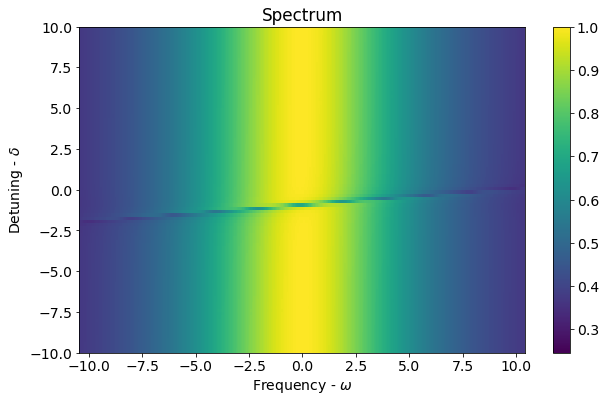

In [203]:
# Solution

tlist = np.linspace(0, 100, 1000)

om_c = 1

g = 0.1
kappa = 10
gamma = 1

Detuning_vec = np.linspace(-10,10,100)

spec_list = []
for Delta in Detuning_vec:
    w1,spec1 = jc_model_damped_spectrum(tlist, om_c, Delta, g, kappa, gamma, N=10)
    spec_list.append(spec1)
plt.subplots(1,1,figsize = (10,6))
z_min, z_max = -np.abs(spec_list).max(), np.abs(spec_list).max()

plt.pcolor(w1-om_c,Detuning_vec,np.abs(spec_list)/z_max)
plt.axis([np.min(w1)/3,np.max(w1)/3,np.min(Detuning_vec),np.max(Detuning_vec)])
plt.xlabel('Frequency - $\omega$')
plt.ylabel('Detuning - $\delta$')
plt.title('Spectrum')
plt.colorbar()
plt.show()

